In [ ]:
"""
Purpose: Do the synaptic density plot

1) Bin the data according to orientation difference and receptive field correlation
- Add in the filter that only looks at the ones that have a significant number of contacts
2) Plot the average synaptic density for each group
a. Do for regular bin size
b. Do this for more equal bin size

Repeat the analysis for binary conversion
"""

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from funconnect import morphology, connectomics, ta3, nda
from tqdm import tqdm
import scipy.stats as stats


Connecting celiib@10.28.0.34:3306


In [5]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20


pinky = dj.create_virtual_module('pinky', 'microns_pinky')
pinky_nda = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')


In [6]:
synapse = (pinky.Synapse - pinky.SynapseExclude) & pinky.CurrentSegmentation
segment = (pinky.Segment - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = (pinky.AllenSoma - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = soma & "cell_class='excitatory'"

In [7]:
"""
WHERE THE RF CORRELATION BINS ARE EXPLICITELY SET
"""

attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.25'

cbin_edges = np.linspace(-.7, .7, 6) #setting the bin boundaries
#calculates the centers of the bins used for the receptive field
cbin_centers = np.hstack((np.nan, np.round((cbin_edges[1:] + cbin_edges[:-1])/2, decimals=2), np.nan))
#creates labels for the receptive field edges
cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(cbin_edges[:-1], cbin_edges[1:])]
cbin_labels

['[-0.7,-0.4]', '[-0.4,-0.1]', '[-0.1,0.1]', '[0.1,0.4]', '[0.4,0.7]']

In [8]:
"""
Calculate the bins and centers for the orientational preference
"""
#defines how to find the "tuned" segments of the orientation
dori_resolution = np.pi / 2 / 4 #setting the width size of the bins to be 22.5 degrees
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9) #creates 8 bins between boundaries between 0 and pi

# turns all of the bin edges into degrees with no decimal
be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in bin_edges]])
#creates the bin boundary markings with [low - high]
bin_labels = list(zip(be[:-1], be[1:]))

#calculates the bin centers
bin_centers = np.round((bin_edges[1:] + bin_edges[:-1])/2 * rad2deg, decimals=2) 

In [14]:
"""
Gets the segments with the acceptable rf thresholds
"""

# functional metrics for each functional soma pair (restricting by spattune fitting significance)

sig_units_rf = spattune.BestSTA.Loc & 'sta_snr > 1.25' & segment
sig_unit_pairs_rf = (sig_units_rf.proj(segment_id1 = 'segment_id') * 
                  sig_units_rf.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

print("Number of significant receptive field neurons = " + str(len(sig_units_rf)))

rf_table = (spattune.BestSTACorr.proj(rf_corr_coef="union_corr_r2",
                          segment_a="segment_id1",segment_b="segment_id2")
                          & sig_units_rf.proj(segment_a="segment_id") &
                          sig_units_rf.proj(segment_b="segment_id"))
len(rf_table)
# attrs_rf = ['n_syn_a', 'n_syn_b', 'n_syn_union', 'n_syn_shared', 'n_seg_a', 'n_seg_b', 'n_seg_union', 'n_seg_shared']
# spatconn_df_rf = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs_rf) * fc.SharedInput.proj(*attrs_rf, segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())
# spatconn_df_rf

Number of significant receptive field neurons = 199


19701

In [13]:
"""
build the pref_rel table to use for the orinetation data

This table just needs the 
1) segment_id
2) von_r2 (orientation preference)
--> for all of the tuned segments
"""
tuned = 'confidence > 0.5'
#get the significantly tuned segments
sig_units_op = radtune.BestVonFit.Unit & 'von_p_value <= 0.05' & tuned & segment
print("Number of significanlty orientationally tuned neurons = " + str(len(sig_units_op)))
# sig_unit_pairs_op = (sig_units_op.proj(segment_id1 = 'segment_id') * 
#                  sig_units_op.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'


#gets the significantly tuned neurons and their differences in combinational pairs 
sig_unit_pairs_op = (radtune.BestVonCorr() & sig_units_op.proj(segment_id1="segment_id") 
                 & sig_units_op.proj(segment_id2="segment_id")).proj("diff_pref_ori")

sig_unit_pairs_op = sig_unit_pairs_op.proj(segment_a="segment_id1",
                                           segment_b="segment_id2",
                                           dori="diff_pref_ori")
len(sig_unit_pairs_op)


Number of significanlty orientationally tuned neurons = 299


44551

In [17]:
"""gets table where have every connection from segment_a to segment b anf the number of n_seg_shared stacked on a 
repeat but the ids for a and b are switched  """
shi = fc.SharedInput.proj("n_seg_shared",segment_a="segment_id")
shi

segmentation segmentation id,segment_a segment id unique within each Segmentation,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments
3,648518346341353058,648518346341353574,0
3,648518346341353058,648518346341353607,0
3,648518346341353058,648518346341354313,0
3,648518346341353058,648518346341354496,0
3,648518346341353058,648518346341355048,0
3,648518346341353058,648518346341355198,0
3,648518346341353058,648518346341355275,0
3,648518346341353058,648518346341355736,1
3,648518346341353058,648518346341356241,0
3,648518346341353058,648518346341356256,3


In [87]:
"""
Practice projecting  with lists

"""
practice_stats_list = ["n_seg_union","n_seg_shared_converted","n_seg_shared"]
print(practice_stats_list)
if "n_seg_shared" in practice_stats_list:
    practice_stats_list.remove("n_seg_shared")
print(practice_stats_list)
#fc.ContactCorrelation.proj(*["n_seg_union","n_seg_shared_converted"],"binary_conversion_pearson")

['n_seg_union', 'n_seg_shared_converted', 'n_seg_shared']
['n_seg_union', 'n_seg_shared_converted']


In [61]:
"""
Things will have to account for is the those that don't have any conversions (because those will have nans for some values)
"""
"""
things could end up measuring
binary_conv_jaccard_ones_ratio

binary_conv_jaccard_ones_ratio=null : float                        # a / (a + b + c  + d) for jaccard similarity of binary conversion rate
binary_conv_jaccard_matching_ratio=null : float                        # ( a + d )/ (a + b + c  + d) for jaccard similarity of binary conversion rate


"""

n_seg_shared_threshold = 10
n_seg_shared_converted_threshold = 10
sign_contact_correlations_only_shared_threshold = fc.ContactCorrelation() & "n_seg_shared>" + str(n_seg_shared_threshold)
print("sign_contact_correlations_only_shared_threshold = " + str(len(sign_contact_correlations_only_shared_threshold)))
sign_contact_correlations = sign_contact_correlations_only_shared_threshold & "n_seg_shared_converted>" + str(n_seg_shared_converted_threshold)
print("sign_contact_correlations with both shared number threshold and shared number converted threshold = " + str(len(sign_contact_correlations)))
sign_contact_correlations = sign_contact_correlations.proj("n_seg_shared_converted",
                                                           "binary_conversion_pearson",
                                                           "binary_conv_jaccard_ones_ratio",
                                                           "conversion_pearson",
                                                           "density_pearson",
                                                           "synapse_vol_density_pearson",
                                                           "synapse_vol_density_cosine",
                                                           "binary_conversion_pearson_converted",
                                                           "binary_conv_jaccard_ones_ratio_converted",
                                                           "conversion_pearson_converted",
                                                           "density_pearson_converted",
                                                           "synapse_vol_density_pearson_converted",
                                                           "synapse_vol_density_cosine_converted",
                                                        
                                                           segment_a="segment_id",
                                                           n_seg_shared_contacts="n_seg_shared",
                                                          
                                                          )
len(sign_contact_correlations)


sign_contact_correlations_only_shared_threshold = 304812
sign_contact_correlations with both shared number threshold and shared number converted threshold = 191843


191843

In [77]:
"""
How to remove the nans

"""

fc.ContactCorrelation() & "n_seg_a_converted_prop='np.nan'"

segmentation segmentation id,segment_id segment id unique within each Segmentation,segment_b id of the postsynaptic neuron,n_seg_a n_presyns contacting onto segment_id,n_seg_b n_presyns contacting onto segment_b,n_seg_shared n_presyns contacting onto both segment_id and segment_b,n_seg_union n_presyns contacting either segment_id or segment_b,n_seg_shared_converted n_presyns contacting onto both and converting on at least 1 postsyn,n_seg_a_converted n_presyns contacting onto both and converting on postsyna a,n_seg_a_converted_prop proportion of n_presyns contacting onto both which convert at least onto postsyna a,n_seg_b_converted n_presyns contacting onto both and converting on postsyna b,n_seg_b_converted_prop proportion of n_presyns contacting onto both which convert at least onto postsyna b,binary_conversion_pearson pearson correlation for binary n_synapse/n_contact rate,binary_conversion_cosine cosine similarity correlation for binary n_synapse/n_contact rate,binary_conv_jaccard_ones_ratio a / (a + b + c + d) for jaccard similarity of binary conversion rate,binary_conv_jaccard_matching_ratio ( a + d )/ (a + b + c + d) for jaccard similarity of binary conversion rate,conversion_pearson Pearson correlation for n_synapse/n_contact rate,conversion_cosine cosine similarity for n_synapse/n_contact rate,density_pearson Pearson correlation for n_synapse/postsyn_length rate,density_cosine cosine similarity for n_synapse/postsyn_length rate,synapse_volume_mean_pearson Pearson correlation for mean of synaptic volume,synapse_volume_mean_cosine cosine similarity for mean of synaptic volume,synapse_vol_density_pearson Pearson correlation for n_synapses*synapse_sizes_mean/postsyn_length rate,synapse_vol_density_cosine cosine similarity for n_synapses*synapse_sizes_mean/postsyn_length rate,binary_conversion_pearson_converted pearson correlation for binary n_synapse/n_contact rate for axon group with at least 1 conversion,binary_conversion_cosine_converted cosine similarity correlation for binary n_synapse/n_contact rate for axon group with at least 1 conversion,binary_conv_jaccard_ones_ratio_converted a / (a + b + c + d) for jaccard similarity of binary conversion rate with at least 1 conversion,binary_conv_jaccard_matching_ratio_converted ( a + d )/ (a + b + c + d) for jaccard similarity of binary conversion rate with at least 1 conversion,conversion_pearson_converted Pearson correlation for n_synapse/n_contact rate for axon group with at least 1 conversion,conversion_cosine_converted cosine similarity for n_synapse/n_contact rate for axon group with at least 1 conversion,density_pearson_converted Pearson correlation for n_synapse/postsyn_length rate for axon group with at least 1 conversion,density_cosine_converted cosine similarity for n_synapse/postsyn_length rate for axon group with at least 1 conversion,synapse_volume_mean_pearson_converted Pearson correlation for mean of synaptic volume for axon group with at least 1 conversion,synapse_volume_mean_cosine_converted cosine similarity for mean of synaptic volume for axon group with at least 1 conversion,synapse_vol_density_pearson_converted Pearson correlation for n_synapses*synapse_sizes_mean/postsyn_length rate for axon group with at least 1 conversion,synapse_vol_density_cosine_converted cosine similarity for n_synapses*synapse_sizes_mean/postsyn_length rate for axon group with at least 1 conversion
3,648518346341353058,648518346341354496,1387,500,8,1879,1,0,0.0,1,1.0,nan,0.0,0.0,0.875,nan,0.0,nan,0.0,-1.0,0.0,nan,0.0,nan,nan,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
3,648518346341353058,648518346341358846,1387,807,12,2182,2,0,0.0,2,1.0,nan,0.0,0.0,0.833333,nan,0.0,nan,0.0,-1.0,0.0,nan,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,nan,0.0,-1.0,0.0,nan,0.0
3,648518346341353058,648518346341361837,1387,364,3,1748,2,0,0.0,2,1.0,nan,0.0,0.0,0.333333,nan,0.0,nan,0.0,-1.0,0.0,nan,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,nan,0.0,-1.0,0.0,nan,0.0
3,648518346341353058,648518346341363182,1387,1299,35,2651,3,0,0.0,3,1.0,

In [ ]:
sign_contact_correlations

In [62]:
sign_contact_correlations

segmentation segmentation id,segment_a segment id unique within each Segmentation,segment_b id of the postsynaptic neuron,n_seg_shared_contacts n_presyns contacting onto both segment_id and segment_b,n_seg_shared_converted n_presyns contacting onto both and converting on at least 1 postsyn,binary_conversion_pearson pearson correlation for binary n_synapse/n_contact rate,binary_conv_jaccard_ones_ratio a / (a + b + c + d) for jaccard similarity of binary conversion rate,conversion_pearson Pearson correlation for n_synapse/n_contact rate,density_pearson Pearson correlation for n_synapse/postsyn_length rate,synapse_vol_density_pearson Pearson correlation for n_synapses*synapse_sizes_mean/postsyn_length rate,synapse_vol_density_cosine cosine similarity for n_synapses*synapse_sizes_mean/postsyn_length rate,binary_conversion_pearson_converted pearson correlation for binary n_synapse/n_contact rate for axon group with at least 1 conversion,binary_conv_jaccard_ones_ratio_converted a / (a + b + c + d) for jaccard similarity of binary conversion rate with at least 1 conversion,conversion_pearson_converted Pearson correlation for n_synapse/n_contact rate for axon group with at least 1 conversion,density_pearson_converted Pearson correlation for n_synapse/postsyn_length rate for axon group with at least 1 conversion,synapse_vol_density_pearson_converted Pearson correlation for n_synapses*synapse_sizes_mean/postsyn_length rate for axon group with at least 1 conversion,synapse_vol_density_cosine_converted cosine similarity for n_synapses*synapse_sizes_mean/postsyn_length rate for axon group with at least 1 conversion
3,648518346341353058,648518346341355736,134,20,0.0202594,0.00746269,0.0343726,-0.0376097,-0.0341714,0.00752274,-0.902671,0.05,-0.575225,-0.522068,-0.36192,0.00752274
3,648518346341353058,648518346341356256,579,86,-0.030253,0.00345423,-0.0108341,-0.0257683,-0.0168042,0.00727687,-0.952511,0.0232558,-0.700804,-0.287689,-0.181607,0.00727687
3,648518346341353058,648518346341357933,355,41,-0.0101669,0.0028169,6.82459e-05,-0.00768465,-0.026608,0.00145427,-0.950542,0.0243902,-0.566629,-0.128053,-0.314563,0.00145427
3,648518346341353058,648518346341359123,436,89,0.0039757,0.0114679,0.0226183,0.0764956,0.189279,0.215445,-0.888256,0.0561798,-0.629858,-0.367994,0.0677751,0.215445
3,648518346341353058,648518346341361018,167,14,-0.0433021,0.0,-0.0408334,-0.0284396,-0.0134994,0.0,-1.0,0.0,-0.829257,-0.509028,-0.19307,0.0
3,648518346341353058,648518346341361981,198,16,0.295228,0.0151515,0.315917,0.198794,0.192555,0.211562,-0.654654,0.1875,-0.569803,-0.61526,-0.115523,0.211562
3,648518346341353058,648518346341362995,384,64,0.0125616,0.0078125,0.00678188,0.104852,0.00991908,0.0344412,-0.900154,0.046875,-0.737676,-0.155412,-0.134814,0.0344412
3,648518346341353058,648518346341363175,83,13,0.114684,0.0120482,0.124025,0.0389358,0.0756325,0.102441,-0.778499,0.0769231,-0.661693,-0.298804,-0.104103,0.102441
3,648518346341353058,648518346341366161,379,37,0.0105385,0.00263852,0.024506,-0.00938926,-0.0214176,0.00265549,-0.938835,0.027027,-0.712968,-0.377347,-0.319234,0.00265549
3,648518346341353058,648518346341366757,712,135,0.0133446,0.00983146,-0.0059915,-0.0313263,-0.0233624,0.00940298,-0.886569,0.0518519,-0.754486,-0.435589,-0.192044,0.00940298


In [63]:
shi

segmentation segmentation id,segment_a segment id unique within each Segmentation,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments
3,648518346341353058,648518346341353574,0
3,648518346341353058,648518346341353607,0
3,648518346341353058,648518346341354313,0
3,648518346341353058,648518346341354496,0
3,648518346341353058,648518346341355048,0
3,648518346341353058,648518346341355198,0
3,648518346341353058,648518346341355275,0
3,648518346341353058,648518346341355736,1
3,648518346341353058,648518346341356241,0
3,648518346341353058,648518346341356256,3


In [90]:
x = [1,3,4,5]
y = x.copy()
y.append(6)
print(y)
print(x)

[1, 3, 4, 5, 6]
[1, 3, 4, 5]


In [64]:
print("len(shi) = " + str(len(shi)))
print("len(shi restricted by the contact correlations with n_seg_shared threshold) = " + str(len(shi & sign_contact_correlations_only_shared_threshold.proj(segment_a="segment_id"))))
print("len(shi restricted by the contact correlations with n_seg_shared threshold AND converted threshold) = " + str(len(shi & sign_contact_correlations)))

new_shi = shi * sign_contact_correlations

""" takes all of the possible shared input combinations:
1) gets this correlation table and renames seg a and b and uses that to restrict the shared input combinations and attach the rf correlation
2) Further restricts to only those TUNED with prefered orientation (and adds on the orientation for a and b)
3) Restrict to only significant rective fields for both segment A and B by DOES NOT ATTACH THE RF score

"""
crel = shi * rf_table * sig_unit_pairs_op
new_crel =  new_shi * rf_table * sig_unit_pairs_op
print((len(crel),len(new_crel)))
crel = new_crel

len(shi) = 314028
len(shi restricted by the contact correlations with n_seg_shared threshold) = 151919
len(shi restricted by the contact correlations with n_seg_shared threshold AND converted threshold) = 77312
(3081, 1637)


In [66]:
cdf = pd.DataFrame(crel.fetch())
#drop any rows with nans
cdf = cdf.dropna()

stats_list = ["n_seg_shared",
        "n_seg_shared_converted",
       "binary_conversion_pearson",
       "binary_conv_jaccard_ones_ratio",
       "conversion_pearson",
       "density_pearson",
       "synapse_vol_density_pearson",
       "synapse_vol_density_cosine",
       "binary_conversion_pearson_converted",
       "binary_conv_jaccard_ones_ratio_converted",
       "conversion_pearson_converted",
       "density_pearson_converted",
       "synapse_vol_density_pearson_converted",
        "synapse_vol_density_cosine_converted"
             ]

#gets the bins of the correlations of the receptive fields
cdf['bcorr'] = cbin_centers[(np.digitize(cdf['rf_corr_coef'], cbin_edges))]
#makes the bins of the corelation of the receptive fields as floats
cdf['bcorr'] = np.array(cdf['bcorr']).astype(float)
#bins the difference in orientation
cdf['bdori'] = bin_centers[(np.digitize(np.abs(cdf["dori"]), bin_edges))-1]


#makes the stats all floats
for s in stats_list:
    cdf[s] = np.array(cdf[s]).astype(float)

cdf

,segmentation,segment_a,segment_b,sta_hash1,sta_hash2,apert_radius,von_hash1,von_hash2,n_seg_shared,n_seg_shared_contacts,...,binary_conversion_pearson_converted,binary_conv_jaccard_ones_ratio_converted,conversion_pearson_converted,density_pearson_converted,synapse_vol_density_pearson_converted,synapse_vol_density_cosine_converted,rf_corr_coef,dori,bcorr,bdori
0,3,648518346341366913,648518346341367107,b7a191fac5a9ce85d6257f222515cc3f,1c15ba3fbf5378c195b38f40587eea64,20,44474bbe7b563dc5dee23b57fddb34e9,e83a2710d7a882bf349398e194eb5fb5,0.0,56,...,-1.000000,0.000000,-0.769206,-0.625728,-0.310874,0.000000,-0.547090,0.024569,-0.56,11.25
1,3,648518346341366913,648518346349471565,b7a191fac5a9ce85d6257f222515cc3f,0c9690706ee3325ab0922419658f3d61,20,44474bbe7b563dc5dee23b57fddb34e9,ea7d60f34fe148d38a772c45ffd9d8d2,0.0,133,...,-1.000000,0.000000,-0.734627,-0.603568,-0.353998,0.000000,-0.000473,-0.197077,-0.00,11.25
2,3,648518346341366913,648518346349472601,b7a191fac5a9ce85d6257f222515cc3f,3dc98805f5cf0c7fafe0924724da80b3,20,44474bbe7b563dc5dee23b57fddb34e9,dfcc9f470ee6f11b6d2c17ebd63e6394,0.0,69,...,-1.000000,0.000000,-0.704455,-0.656740,-0.330258,0.000000,0.137449,0.482774,-0.00,33.75
3,3,648518346341366913,648518346349473804,b7a191fac5a9ce85d6257f222515cc3f,ae479d995f0afe0bd95b96da70bb8c08,20,44474bbe7b563dc5dee23b57fddb34e9,75bb02f22c6d11666ae581cbed345d0d,0.0,79,...,-1.000000,0.000000,-0.729491,-0.494381,-0.317344,0.000000,-0.043242,-0.840345,-0.00,56.25
4,3,648518346341366913,648518346349491953,b7a191fac5a9ce85d6257f222515cc3f,78eac735b763d65c41768fee6b4ae6ce,20,44474bbe7b563dc5dee23b57fddb34e9,38bf00d354e6cafde363b0f174946c0d,3.0,148,...,-0.786912,0.090909,-0.505049,-0.411034,-0.222379,0.012057,-0.485549,-0.472809,-0.56,33.75
5,3,648518346341366913,648518346349493653,b7a191fac5a9ce85d6257f222515cc3f,73ab60252d0e18998faf21a46886a395,20,44474bbe7b563dc5dee23b57fddb34e9,c58b95168e713f24be6938c707e03493,1.0,101,...,-0.872872,0.066667,-0.677301,-0.685960,-0.306156,0.000658,0.144929,0.152055,0.28,11.25
6,3,648518346341366913,648518346349498286,b7a191fac5a9ce85d6257f222515cc3f,1149e81487b2d2b4a79e705cb4468369,20,44474bbe7b563dc5dee23b57fddb34e9,f9078c122c2fe1b57c88ce8f6396d146,0.0,152,...,-1.000000,0.000000,-0.568469,-0.509931,-0.388366,0.000000,-0.524252,-1.300420,-0.56,78.75
7,3,648518346341366913,648518346349498482,b7a191fac5a9ce85d6257f222515cc3f,c5a6de7d3ea65f005197b4a028ed019a,20,44474bbe7b563dc5dee23b57fddb34e9,ef8a969303c6494f7c496c5789d6a66b,1.0,185,...,-1.000000,0.000000,-0.687221,-0.545624,-0.271367,0.000000,0.116521,-0.432571,-0.00,33.75
8,3,648518346341366913,648518346349499085,b7a191fac5a9ce85d6257f222515cc3f,34a7238e90a8f1fa366d93b4a6309b45,20,44474bbe7b563dc5dee23b57fddb34e9,49ac3d385cc310c3b98173bff4e7f648,0.0,137,...,-1.000000,0.000000,-0.719810,-0.532038,-0.285860,0.000000,0.381318,0.047653,0.28,11.25
9,3,648518346341366913,648518346349499783,b7a191fac5a9ce85d6257f222515cc3f,3bb286e44259ea864a550563e73076b8,20,44474bbe7b563dc5dee23b57fddb34e9,b9f8f45e8d68dde7a297d8dc99e3b1fb,0.0,78,...,-1.000000,0.000000,-0.774711,-0.539599,-0.244181,0.000000,0.271337,-0.282808,0.28,11.25


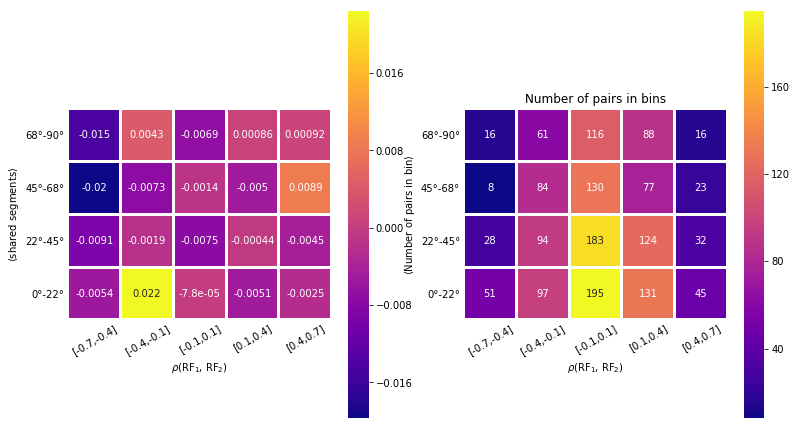

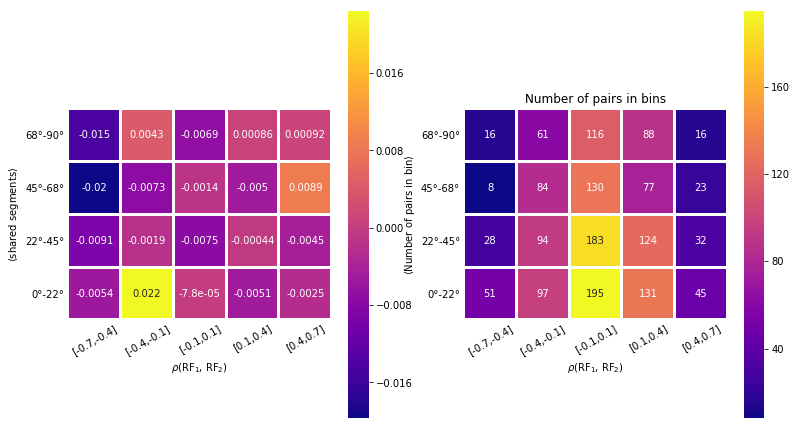

In [96]:
#calculates the actual histograms
gs = plt.GridSpec(1,2)
fig = plt.figure(figsize=(13,7.5))
ax_heat_shared = fig.add_subplot(gs[0,0])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['synapse_vol_density_pearson'].mean().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'synapse_vol_density_pearson')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_shared)
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$shared segments$\rangle$')

ax_heat_count = fig.add_subplot(gs[0,1])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['synapse_vol_density_pearson'].count().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'synapse_vol_density_pearson')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_count,fmt='g')
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$Number of pairs in bin$\rangle$')

# g.set_title('add title here')
plt.title('Number of pairs in bins')
plt.show()





Text(491.6727272727271, 0.5, '$\\langle$Number of pairs in bin$\\rangle$')

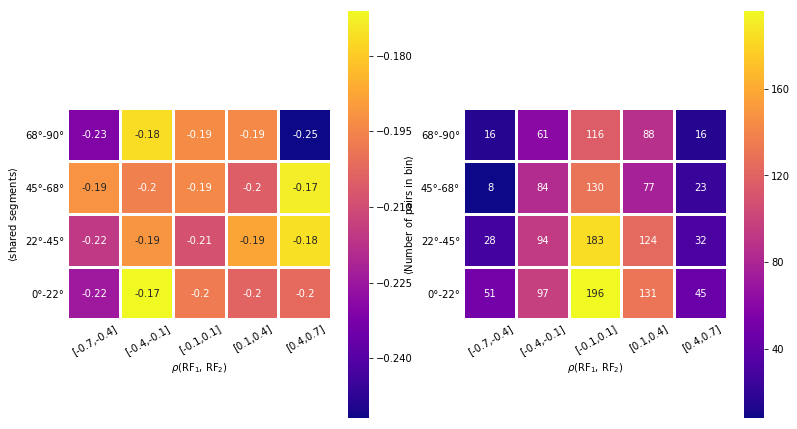

In [68]:
#calculates the actual histograms
gs = plt.GridSpec(1,2)
fig = plt.figure(figsize=(13,7.5))
ax_heat_shared = fig.add_subplot(gs[0,0])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['synapse_vol_density_pearson_converted'].mean().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'synapse_vol_density_pearson_converted')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_shared)
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$shared segments$\rangle$')

ax_heat_count = fig.add_subplot(gs[0,1])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['synapse_vol_density_pearson_converted'].count().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'synapse_vol_density_pearson_converted')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_count,fmt='g')
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$Number of pairs in bin$\rangle$')



Text(491.6727272727271, 0.5, '$\\langle$Number of pairs in bin$\\rangle$')

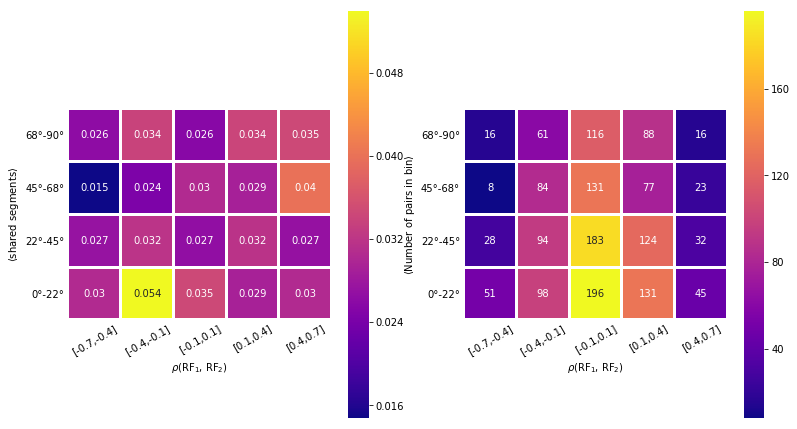

In [69]:
#calculates the actual histograms
gs = plt.GridSpec(1,2)
fig = plt.figure(figsize=(13,7.5))
ax_heat_shared = fig.add_subplot(gs[0,0])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['synapse_vol_density_cosine'].mean().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'synapse_vol_density_cosine')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_shared)
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$shared segments$\rangle$')

ax_heat_count = fig.add_subplot(gs[0,1])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['synapse_vol_density_cosine'].count().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'synapse_vol_density_cosine')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_count,fmt='g')
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$Number of pairs in bin$\rangle$')



Text(491.6727272727271, 0.5, '$\\langle$Number of pairs in bin$\\rangle$')

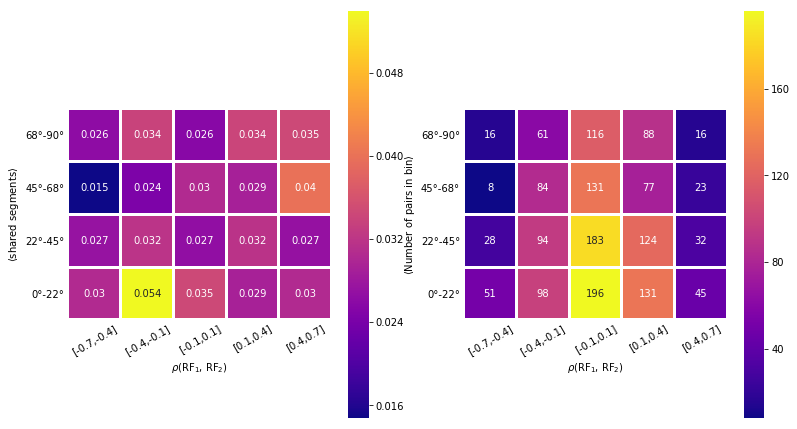

In [70]:
#calculates the actual histograms
gs = plt.GridSpec(1,2)
fig = plt.figure(figsize=(13,7.5))
ax_heat_shared = fig.add_subplot(gs[0,0])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['synapse_vol_density_cosine_converted'].mean().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'synapse_vol_density_cosine_converted')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_shared)
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$shared segments$\rangle$')

ax_heat_count = fig.add_subplot(gs[0,1])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['synapse_vol_density_cosine_converted'].count().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'synapse_vol_density_cosine_converted')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_count,fmt='g')
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$Number of pairs in bin$\rangle$')

